# Ostatni milestone pierwszego projektu z przedmiotu WUM
### Alicja Charuza, Mateusz Gałęziewski

In [75]:
#imports
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import VotingClassifier
import joblib
import pickle
import wordcloud
import matplotlib.pyplot as plt

In [3]:
#load the training data
x_train = pd.read_csv('train_data/tfidf_train_train.csv', index_col=[0])
y_train = pd.read_csv('train_data/y_train_train.csv', index_col=[0])
#load the test data
x_test = pd.read_csv('train_data/tfidf_train_test.csv', index_col=[0])
y_test = pd.read_csv('train_data/y_train_test.csv', index_col=[0])

In [4]:
# solving problems with index after loading data
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
def show_results(model, x, y):
    predict = model.predict(x)
    print('F1 score:',f1_score(y, predict))
    print('Accuracy:',accuracy_score(y, predict))
    print('Recall:',recall_score(y, predict))
    print('Precision:',precision_score(y, predict))
    print('ROC AUC:', roc_auc_score(y, model.predict_proba(x)[:, 1]))

## Regresja logistyczna

In [6]:
# no parameters
log_reg=LogisticRegression()
log_reg.fit(x_train, y_train.values.ravel())
print('Logistic Regression:')
print()
print('Train results:')
show_results(log_reg, x_train, y_train)
print()
print('Test results:')
show_results(log_reg, x_test, y_test)

Logistic Regression:

Train results:
F1 score: 0.9434208506064793
Accuracy: 0.9553170850006063
Recall: 0.929154695297142
Precision: 0.9581319195384376
ROC AUC: 0.9905163082141264

Test results:
F1 score: 0.9350767275038592
Accuracy: 0.9494234986206409
Recall: 0.9179889463362453
Precision: 0.9528127313101407
ROC AUC: 0.9867215589592845


Regresja logistyczna radzi sobie całkiem dobrze, dlatego też nie będziemy dobierać do niej hiperparametrów.

## Decision Tree

In [6]:
#Decision Tree
tree=DecisionTreeClassifier()  
tree.fit(x_train,y_train.values.ravel())
print('Decision Tree:')
print()
print('Train results:')
show_results(tree, x_train, y_train)
print()
print('Test results:')
show_results(tree, x_test, y_test)

Decision Tree:

Train results:
F1 score: 0.999886574161594
Accuracy: 0.9999090578392142
Recall: 0.9997731740511114
Precision: 1.0
ROC AUC: 0.9999999827831736

Test results:
F1 score: 0.9105253720638335
Accuracy: 0.9294051071655939
Recall: 0.9053307184881441
Precision: 0.9157799819657348
ROC AUC: 0.9253636756893989


Porównując wyniki zbioru treningowego i testowego widzimy, że drzewo się przeucza. Spróbujmy dobrać hiperparametry.

In [12]:
param_distributions = {
    'max_depth': randint(low=1, high=20),
    'min_samples_leaf': randint(low=1, high=10),
    'min_samples_split': randint(low=2, high=10)
}

tree2 = DecisionTreeClassifier()
search = RandomizedSearchCV(tree2, param_distributions, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
search.fit(x_train, y_train)
print(search.best_params_)

{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}


Spróbujmy teraz użyć tych parametrów do nowego modelu.

In [7]:
tree3 = DecisionTreeClassifier(max_depth=12, min_samples_leaf=1, min_samples_split=2)
tree3.fit(x_train, y_train)
print('Decision Tree with parameters:')
print()
print('Train results:')
show_results(tree3, x_train, y_train)
print()
print('Test results:')
show_results(tree3, x_test, y_test)

Decision Tree with parameters:

Train results:
F1 score: 0.9538954442447448
Accuracy: 0.9642294167576089
Recall: 0.9229547860275216
Precision: 0.9869825355756792
ROC AUC: 0.977804798162706

Test results:
F1 score: 0.9204881656804734
Accuracy: 0.939166725613638
Recall: 0.8875022285612408
Precision: 0.9560207413097753
ROC AUC: 0.9379687086587256


Dzięki wprowadzonym zmianom udało nam się uniknąć przeuczenia modelu i doprowadziliśmy do poprawienia wyników.

## Random Forest

In [8]:
rand_forest=RandomForestClassifier()
rand_forest.fit(x_train,y_train.values.ravel())
print('Random Forest:')
print()
print('Train results:')
show_results(rand_forest, x_train, y_train)
print()
print('Test results:')
show_results(rand_forest, x_test, y_test)

Random Forest:

Train results:
F1 score: 0.9998865827378927
Accuracy: 0.9999090578392142
Recall: 0.999848782700741
Precision: 0.9999243856332704
ROC AUC: 0.9999999827831736

Test results:
F1 score: 0.9313276651406147
Accuracy: 0.9480087713093301
Recall: 0.8885719379568551
Precision: 0.9784059678052611
ROC AUC: 0.9880500511440169


Patrząc na wyniki ponownie możemy podejrzewać, że model się przeuczył. Spróbujmy dobrać hiperparametry, aby poprawić jakość modelu. Zastosujemy do tego RandomizedSearch i crosswalidację.

In [6]:
param_dist = {
    'max_depth': [10, 20, 30, 40, 50]
}
rf = RandomForestClassifier()
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
random_search.fit(x_train, y_train.values.ravel())
print(random_search.best_params_)

C:\Users\alicj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'max_depth': 50}


In [8]:
rand_forest_2 = RandomForestClassifier(max_depth=50)
rand_forest_2.fit(x_train, y_train.values.ravel())
print('Random Forest with parameters:')
print()
print('Train results:')
show_results(rand_forest_2, x_train, y_train)
print()
print('Test results:')
show_results(rand_forest_2, x_test, y_test)

Random Forest with parameters:

Train results:
F1 score: 0.9968526032384057
Accuracy: 0.9974839335515945
Recall: 0.9938000907303796
Precision: 0.999923925446938
ROC AUC: 0.9999900467613596

Test results:
F1 score: 0.933308529439122
Accuracy: 0.9492820258895098
Recall: 0.8944553396327332
Precision: 0.9756903928432517
ROC AUC: 0.9874540678057946


Jak widać nie zaszła większa poprawa w porównaniu do Random Forest bez hiperparametrów.

## SVM

Ze względu na długi czas przewidywania, zdecydowaliśmy się zrezygnować z użycia Support Vector Machine w ostatecznym modelu, aby przyspieszyć jego działanie w warunkach wdrożenia. Jego wyniki można zobaczyć w drugim milestonie.

## Soft Voting

In [15]:
clf = VotingClassifier(estimators=[('1', log_reg), ('2', tree3), ('3', rand_forest_2)],voting="soft")
clf.fit(x_train, y_train.values.ravel())
print('Voting:')
print()
print('Train results:')
show_results(clf, x_train, y_train.values.ravel())
print()
print('Test results:')
show_results(clf, x_test, y_test.values.ravel())

Voting:

Train results:
F1 score: 0.9689253511860996
Accuracy: 0.9756578149630168
Recall: 0.9465446847119311
Precision: 0.9923900118906064
ROC AUC: 0.9990893274454133

Test results:
F1 score: 0.937482685381845
Accuracy: 0.9521114805121312
Recall: 0.904974148689606
Precision: 0.9724137931034482
ROC AUC: 0.9904433816664922


Łączac powstałe modele w VotingClassifier, uzyskaliśmy jak dotąd najlepszy rezultat na zbiorze testowym.

In [18]:
# saving model to a file
filename = "fake_news_model.joblib"
joblib.dump(clf, filename)

['fake_news_model.joblib']

Spójrzmy jeszcze na predykcyjność zmiennych w uzyskanym modelu.

Najpierw predykcyjność zmiennych w regreji logistycznej.

In [45]:
df_log = pd.DataFrame(log_reg.coef_.transpose(), 
             x_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
print(df_log)

                 coef
reuter      26.059102
said        13.885115
tuesday      4.610065
friday       4.603673
washington   4.489670
...               ...
octob       -4.529976
novemb      -4.540267
hillari     -5.503802
video       -6.920072
via        -10.291338

[2885 rows x 1 columns]


Zobaczmy 30 zmiennych najbardziej wpływających na wynik, że news jest prawdziwy.

In [48]:
print(df_log.head(30))

                 coef
reuter      26.059102
said        13.885115
tuesday      4.610065
friday       4.603673
washington   4.489670
that         4.457917
monday       4.453538
thursday     4.203014
say          3.932131
dont         3.620795
wednesday    3.597972
what         3.538014
statement    3.383051
there        3.334976
he           3.167417
reform       2.977550
im           2.935309
unfold       2.688748
saturday     2.678092
challeng     2.669617
moscow       2.660557
sunday       2.581035
twitter      2.574220
ive          2.573338
your         2.494889
conserv      2.476904
minist       2.457704
spokesman    2.444441
whether      2.433826
northern     2.429723


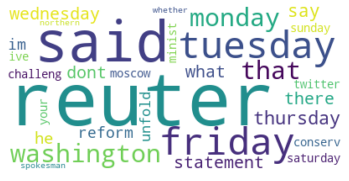

In [76]:
word_dict = df_log.head(30).to_dict()
wc = wordcloud.WordCloud(background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['coef'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

A teraz 30 zmiennych najbardziej wpływających na wynik, że news jest fałszywy.

In [50]:
print(df_log.tail(30))

                coef
fbi        -2.380904
cent       -2.388750
centuri    -2.403650
anyon      -2.412466
dc         -2.429191
american   -2.462960
rt         -2.474296
watch      -2.511947
imag       -2.563313
taxpay     -2.595213
fact       -2.697720
america    -2.713172
breitbart  -2.737427
news       -2.768114
howev      -2.771756
today      -2.915085
entir      -2.915201
rep        -3.098609
know       -3.167364
go         -3.232380
break      -3.317260
even       -3.460338
daili      -3.544742
articl     -3.610407
wire       -4.213001
octob      -4.529976
novemb     -4.540267
hillari    -5.503802
video      -6.920072
via       -10.291338


<ipython-input-80-6b31359fcc43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail['coef'] = tail['coef'].map(lambda x: abs(x))


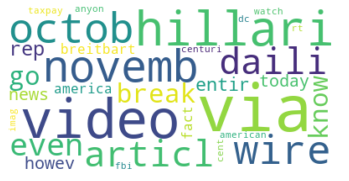

In [80]:
tail = df_log.tail(30)
tail['coef'] = tail['coef'].map(lambda x: abs(x))
word_dict = tail.to_dict()
wc = wordcloud.WordCloud(background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['coef'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Spójrzmy teraz, które zmienne najbardziej wpływają na wynik w Decision Tree. Przejrzyjmy znowu 30 najbardziej wpływających.

In [54]:
df_tree = pd.DataFrame(tree3.feature_importances_.transpose(), 
             x_train.columns, 
             columns=['importance'])\
            .sort_values(by='importance', ascending=False)
print(df_tree.head(30))

            importance
reuter        0.804451
said          0.027596
dont          0.009904
gop           0.009895
via           0.009394
that          0.007956
hillari       0.004205
kill          0.004141
your          0.004039
video         0.003496
he            0.003314
unfold        0.003225
sen           0.003101
photo         0.002734
error         0.002536
republican    0.002349
primari       0.002210
wire          0.001937
consequ       0.001909
new           0.001895
cnn           0.001857
occasion      0.001852
rule          0.001817
syrian        0.001757
bbc           0.001457
florida       0.001350
associ        0.001336
obama         0.001272
rt            0.001168
contribut     0.001167


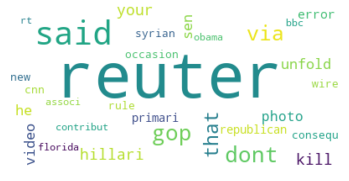

In [81]:
word_dict = df_tree.head(30).to_dict()
wc = wordcloud.WordCloud(background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['importance'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Teraz zróbmy to samo dla Random Forest.

In [55]:
df_forest = pd.DataFrame(rand_forest_2.feature_importances_.transpose(), 
             x_train.columns, 
             columns=['importance'])\
            .sort_values(by='importance', ascending=False)
print(df_forest.head(30))

            importance
reuter        0.134839
said          0.069431
via           0.018965
video         0.016917
minist        0.012813
tuesday       0.011938
washington    0.011111
imag          0.010096
wednesday     0.008324
us            0.007456
thursday      0.007251
hillari       0.006987
presid        0.006772
like          0.006744
friday        0.006158
fact          0.005828
statement     0.005775
spokesman     0.005601
monday        0.005348
lawmak        0.005105
know          0.005094
leader        0.004958
even          0.004901
america       0.004866
told          0.004667
state         0.004241
senat         0.003808
get           0.003695
rule          0.003322
hous          0.003197


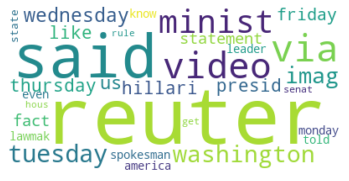

In [82]:
word_dict = df_forest.head(30).to_dict()
wc = wordcloud.WordCloud(background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['importance'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()